<h2>Skip-Gram with Negative Sampling, SGNS

<h4>네거티브 샘플링(Negative Sampling)</h4>
Word2Vec의 출력층에서는 소프트맥스 함수를 지난 단어 집합 크기의 벡터와 실제값인 원-핫 벡터와의 오차를 구하고 이로부터 임베딩 테이블에 있는 모든 단어에 대한 임베딩 벡터 값을 업데이트합니다. 만약 단어 집합의 크기가 수만 이상에 달한다면 이 작업은 굉장히 무거운 작업이므로, Word2Vec은 꽤나 학습하기에 무거운 모델이 됩니다.

Word2Vec은 역전파 과정에서 모든 단어의 임베딩 벡터값의 업데이트를 수행하지만, 만약 현재 집중하고 있는 중심 단어와 주변 단어가 '강아지'와 '고양이', '귀여운'과 같은 단어라면, 사실 이 단어들과 별 연관 관계가 없는 '돈가스'나 '컴퓨터'와 같은 수많은 단어의 임베딩 벡터값까지 업데이트하는 것은 비효율적입니다.

네거티브 샘플링은 Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법입니다. 가령, 현재 집중하고 있는 주변 단어가 '고양이', '귀여운'이라고 해봅시다. 여기에 '돈가스', '컴퓨터', '회의실'과 같은 단어 집합에서 무작위로 선택된 주변 단어가 아닌 단어들을 일부 가져옵니다. 이렇게 하나의 중심 단어에 대해서 전체 단어 집합보다 훨씬 작은 단어 집합을 만들어놓고 마지막 단계를 이진 분류 문제로 변환합니다. 주변 단어들을 긍정(positive), 랜덤으로 샘플링 된 단어들을 부정(negative)으로 레이블링한다면 이진 분류 문제를 위한 데이터셋이 됩니다. 이는 기존의 단어 집합의 크기만큼의 선택지를 두고 다중 클래스 분류 문제를 풀던 Word2Vec보다 훨씬 연산량에서 효율적입니다.

-----

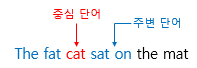

<h4>Skip-gram</h4>
Skip-gram은 중심 단어로부터 주변 단어를 예측하는 모델이었습니다. 위와 같은 문장이 있다고 한다면, Skip-gram은 중심 단어 cat으로부터 주변 단어 The, fat, sat, on을 예측합니다. 기존의 Skip-gram 모델을 일종의 주황 박스로 생각해본다면, 아래의 그림과 같이 입력은 중심 단어, 모델의 예측은 주변 단어인 구조입니다.

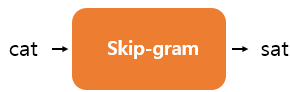

<h4>SGNS</h4>

SGNS는 다음과 같이 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지 그 확률을 예측합니다.

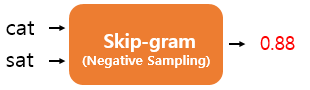

<h4>데이터셋 구조</h4>

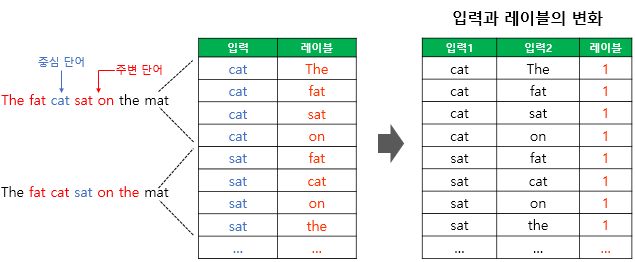

(좌) Skip-gram, (우) SGNS

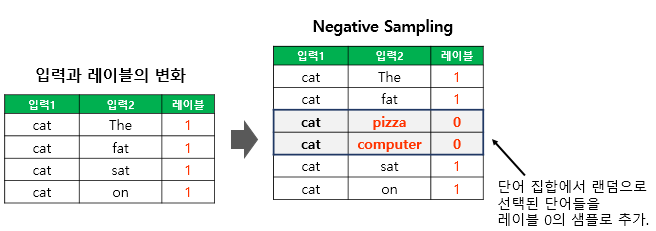

-----
<h4>데이터 전처리</h4>

In [30]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups # 20뉴스 그룹 데이터 활용
from tensorflow.keras.preprocessing.text import Tokenizer

In [31]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [32]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [33]:
news_df.isnull().values.any()

False

In [34]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [35]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 11004


In [36]:
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [37]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.array(tokenized_doc, dtype=object)
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :', len(tokenized_doc))

총 샘플 수 : 10961


In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)


In [39]:
print(encoded[:2])

[[40, 53, 927, 143, 15889, 1684, 546, 279, 871, 12028, 17773, 24007, 29726, 279, 871, 63435, 871, 1128, 1103, 1998, 851, 29727, 913, 731, 20477, 279, 871, 170, 143, 1811, 149, 279, 20478, 17773, 6645, 5710, 76, 63436, 7, 36, 165, 614, 653, 29728, 6911, 24008, 2082, 829, 17774, 1119, 8790, 355, 1072, 15890, 671, 57, 163, 4231, 7206, 1933, 440, 56, 282, 4730, 9275, 2690, 39306], [1283, 429, 3, 52, 6164, 159, 112, 474, 89, 17775, 18, 63, 4731, 2865, 63437, 1042, 402, 39307, 8791, 902, 44, 8328, 316, 13041, 902, 3452, 5923, 533, 18, 87, 4732, 9872, 160, 1403, 120, 151, 5194, 63438, 63439, 17776, 63440, 13041, 903, 63441, 63442, 11172, 17777]]


In [40]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 181839


In [41]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [42]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(ignore (1811), whole (170)) -> 1
(u.s. (279), subsidizing (20478)) -> 1
(daily (2082), clearly (653)) -> 1
(races (9275), 1:39 (75885)) -> 0
(seem (143), think (7)) -> 1


In [43]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [44]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2460
2460


In [45]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

Exception ignored in: <function tqdm.__del__ at 0x0000022536E01A60>
Traceback (most recent call last):
  File "c:\Users\admin\.conda\envs\lang\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\admin\.conda\envs\lang\lib\site-packages\tqdm\std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


In [46]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [47]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

In [48]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 100)               1818390   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 100)               1818390   ['input_4[0][0]']       

In [54]:
from tqdm import tqdm

for epoch in range(1, 6):
    loss = 0
    with tqdm(total=len(skip_grams), desc=str(epoch)) as pbar:
        for _, elem in enumerate(skip_grams):
            first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
            second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
            labels = np.array(elem[1], dtype='int32')
            X = [first_elem, second_elem]
            Y = labels
            loss += model.train_on_batch(X,Y)
            pbar.update(1)
        print('Epoch :',epoch, 'Loss :',loss)

1: 100%|██████████| 10961/10961 [43:25<00:00,  4.21it/s] 


Epoch : 1 Loss : 4795.249150734395


2: 100%|██████████| 10961/10961 [43:16<00:00,  4.22it/s] 


Epoch : 2 Loss : 4107.344502031803


3: 100%|██████████| 10961/10961 [43:19<00:00,  4.22it/s] 


Epoch : 3 Loss : 3771.7666607424617


4: 100%|██████████| 10961/10961 [43:29<00:00,  4.20it/s] 


Epoch : 4 Loss : 3391.233879506588


5: 100%|██████████| 10961/10961 [43:20<00:00,  4.21it/s] 

Epoch : 5 Loss : 3026.065811786335


In [56]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [57]:
w2v.most_similar(positive=['soldiers'])

[('shelling', 0.7856020927429199),
 ('fighting', 0.760459840297699),
 ('wounded', 0.744261622428894),
 ('erzurum', 0.73750239610672),
 ('jordanian', 0.7309987545013428),
 ('lebanon', 0.7266365885734558),
 ('towns', 0.7215852737426758),
 ('hanged', 0.7200069427490234),
 ('greece', 0.7134170532226562),
 ('cypriot', 0.7125051617622375)]

In [58]:
w2v.most_similar(positive=['doctor'])

[('fate', 0.5358836650848389),
 ('medicine', 0.5271480083465576),
 ('unreasonable', 0.5243412852287292),
 ('doctors', 0.5169361233711243),
 ('trumbull', 0.5087291598320007),
 ('interfere', 0.4980449974536896),
 ('terror', 0.49352774024009705),
 ("lyuda's", 0.48896852135658264),
 ('"no,', 0.4852677583694458),
 ('consecration', 0.48335587978363037)]